In [31]:
#####################
# Data Loading
#####################
library(tidyverse)
library(gplots)
library(ComplexHeatmap)
library(cowplot)

In [32]:
#####################
# Config Theme
#####################
theme_set(theme_grey())
options(repr.plot.width=10, repr.plot.height=10, repr.plot.res=200)

In [33]:
#####################
# Color Pallett
#####################
Color_Spectrum <- colorpanel(20, "blue","green","red")
GroupID_Color_List = c("Naive"="#88008A", "CCR6neg"="#FFA500", "CCR6low"="#0456f8", "CCR6int"="#1D8F06", "CCR6high"="#e51134")
GroupID_Order_List = c("Naive", "CCR6neg", "CCR6low", "CCR6int", "CCR6high")
GroupID_Label_List = c("Naive"="Naive", 
                       "CCR6neg"='expression(paste("CCR6"^neg))', 
                       "CCR6low"='expression(paste("CCR6"^low))', 
                       "CCR6int"='expression(paste("CCR6"^int))', 
                       "CCR6high"='expression(paste("CCR6"^high))'
                      )

In [34]:
#####################
# Input/Output
#####################
expression_file_Path = "../Data/Fluidigm_Donor123_Log2_Expression.txt"
gene_list_file_Path = "../Data/Fluidigm_Donor123_Gene_List.txt"
metadata_file_Path = "../Data/Fluidigm_Donor123_sample_design.txt"

In [35]:
#####################
# Read I/O
#####################
#READ I/O
expression_DF = read_tsv(expression_file_Path)
#head(expression_DF)
#dim(expression_DF)
gene_list_DF = read_tsv(gene_list_file_Path)
#head(gene_list_DF)
#dim(gene_list_DF)
metadata_DF = read_tsv(metadata_file_Path)
#head(metadata_DF)
#dim(metadata_DF)

Parsed with column specification:
cols(
  .default = col_double(),
  ID = col_character()
)

See spec(...) for full column specifications.

Parsed with column specification:
cols(
  GeneID = col_character()
)

Parsed with column specification:
cols(
  SampleID = col_character(),
  GroupID = col_character()
)



In [36]:
####################
#Data Wrangling
####################
#1-transposing
transposed_expression_DF = expression_DF %>%  gather(key=SampleID, value=Expression, -ID) %>% spread(ID, Expression)
#head(transposed_expression_DF, n=5L)
#dim(transposed_expression_DF)

#2-leftjoin with metadata
metadata_transposed_expression_DF = metadata_DF %>% inner_join(transposed_expression_DF, by = c("SampleID" = "SampleID"))
#head(metadata_transposed_expression_DF)
#dim(metadata_transposed_expression_DF)

#3 melt(long format) the dataset
gather_metadata_transposed_expression_DF = metadata_transposed_expression_DF %>% gather(key=GeneID, value=Expression, -SampleID, -GroupID, na.rm = FALSE, convert = FALSE)
#head(gather_metadata_transposed_expression_DF)
#dim(gather_metadata_transposed_expression_DF)

#4 Filter Gene by gene list
filtered_gather_metadata_transposed_expression_DF = gather_metadata_transposed_expression_DF %>% filter(GeneID %in% gene_list_DF$GeneID) %>% arrange(match(GroupID, GroupID_Order_List))
#head(filtered_gather_metadata_transposed_expression_DF)
#dim(filtered_gather_metadata_transposed_expression_DF)


#5 spread dataframe
spread_filtered_gather_metadata_transposed_expression_DF = filtered_gather_metadata_transposed_expression_DF %>% select(-c(GroupID))%>%
    spread(key=SampleID, value=Expression) %>% select(GeneID, filtered_gather_metadata_transposed_expression_DF$SampleID)
#head(spread_filtered_gather_metadata_transposed_expression_DF)


#6 Build annotation
annotation_DF = metadata_DF %>% arrange(match(GroupID, GroupID_Order_List))
#head(annotation_DF)
#dim(annotation_DF)
factor_annotation_DF = data.frame(annotation_DF$GroupID)
colnames(factor_annotation_DF) <- c("GroupID")
#rownames(factor_annotation_DF) <- annotation_DF$SampleID
annotation_color_List <- list("GroupID"=GroupID_Color_List)

#7 Build Matrix

#expression_matrix_Dist = spread_filtered_gather_metadata_transposed_expression_DF %>% column_to_rownames(var="GeneID")
#head(expression_matrix_Dist)
expression_matrix_Dist <- as.matrix(spread_filtered_gather_metadata_transposed_expression_DF[,-c(1:1)], method=NA)
rownames(expression_matrix_Dist) <- spread_filtered_gather_metadata_transposed_expression_DF$GeneID
dim(expression_matrix_Dist)

expression_matrix_Dist_scaled = t(apply(expression_matrix_Dist, 1, scale))
head(expression_matrix_Dist_scaled)

[1]   26 1352

BATF,0.3806003,-2.3379053,0.4056079,0.60120568,0.0702928,-2.33790526,-0.6353599,-2.3379053,-0.2485888,0.8348860,⋯,0.7148230,-0.1110674,0.2979169,0.1160145,0.1810772,0.1504358,0.3621087,-0.1594021,0.33012528,0.4294616
CCL20,-0.7263525,-0.7263525,-0.7263525,-0.72635251,-0.7263525,-0.72635251,-0.2364064,-0.7263525,-0.7263525,-0.7263525,⋯,1.6640990,1.5785140,1.6983141,1.2445359,1.7454494,0.8920094,1.6045129,1.4730180,0.80707722,1.5434567
CCR6,-0.9522783,-0.9522783,-0.9522783,-0.95227825,0.2699408,-0.95227825,-0.9522783,-0.9522783,-0.2897427,0.9696167,⋯,1.0922372,1.4410635,1.2469015,1.2349953,0.8860456,0.8389156,-0.9522783,1.0869367,-0.47410149,1.1469259
CXCR3,1.4817537,-0.7704763,-0.7704763,-0.77047635,-0.7704763,-0.77047635,-0.7704763,-0.7704763,1.6654850,-0.7704763,⋯,-0.7704763,-0.7704763,1.3864862,-0.7704763,-0.7704763,-0.7704763,-0.7704763,-0.7704763,-0.77047635,-0.2011071
CXCR5,-0.9238962,0.8970356,-0.9238962,0.65850750,-0.9238962,-0.09565364,-0.9238962,-0.9238962,0.8454540,0.4767447,⋯,1.9878970,0.4408457,-0.9238962,-0.7665499,1.6992446,1.1813718,-0.9238962,-0.9238962,-0.85035678,1.5482743
EOMES,-0.7989115,-0.7989115,-0.7989115,-0.05908308,-0.7989115,-0.79891154,-0.7989115,0.8719201,0.4641592,0.3625912,⋯,-0.7989115,-0.7989115,-0.7989115,-0.7989115,-0.7989115,-0.7989115,-0.7989115,-0.3277983,0.02567657,-0.7989115


In [37]:

####################
# Heatmap
####################
Annotation_Heatmap_Object <- HeatmapAnnotation(df=factor_annotation_DF, 
                                               show_legend = FALSE, 
                                               which="col", 
                                               col=annotation_color_List, 
                                               annotation_width=unit(c(1,2), "cm"), 
                                               gap=unit(1, "mm"),
                                               annotation_legend_param = list(
                                                    title=" ", 
                                                    #nrow=1, 
                                                    title_gp = gpar(fontfamily="sans", fontsize = 15, fontface = "plain")
                                               )
                                              )
expression_heatmap_Object = Heatmap(expression_matrix_Dist_scaled,
    col = Color_Spectrum,
    top_annotation=Annotation_Heatmap_Object,
    heatmap_legend_param = list(col_fun = colors, title="", legend_height = unit(6, "cm"),color_bar="continuous"),
    column_order = NULL,
    cluster_rows = TRUE,
    show_row_names = TRUE,
    row_dend_reorder = FALSE,
    clustering_distance_rows ="pearson",
    clustering_method_rows = "complete",
    
    row_dend_width = unit(1.0, "cm"),
    row_dend_side = "left",                                
    cluster_columns = FALSE,
    show_column_names = FALSE,
    column_dend_reorder = NULL,
    clustering_distance_columns =NULL,
    clustering_method_columns = NULL,
    #rect_gp = gpar(col = "white", lwd = 0.2),
    show_heatmap_legend = TRUE
)

expression_heatmap_Object = plot_grid(grid.grabExpr(draw(expression_heatmap_Object)), nrow=1)

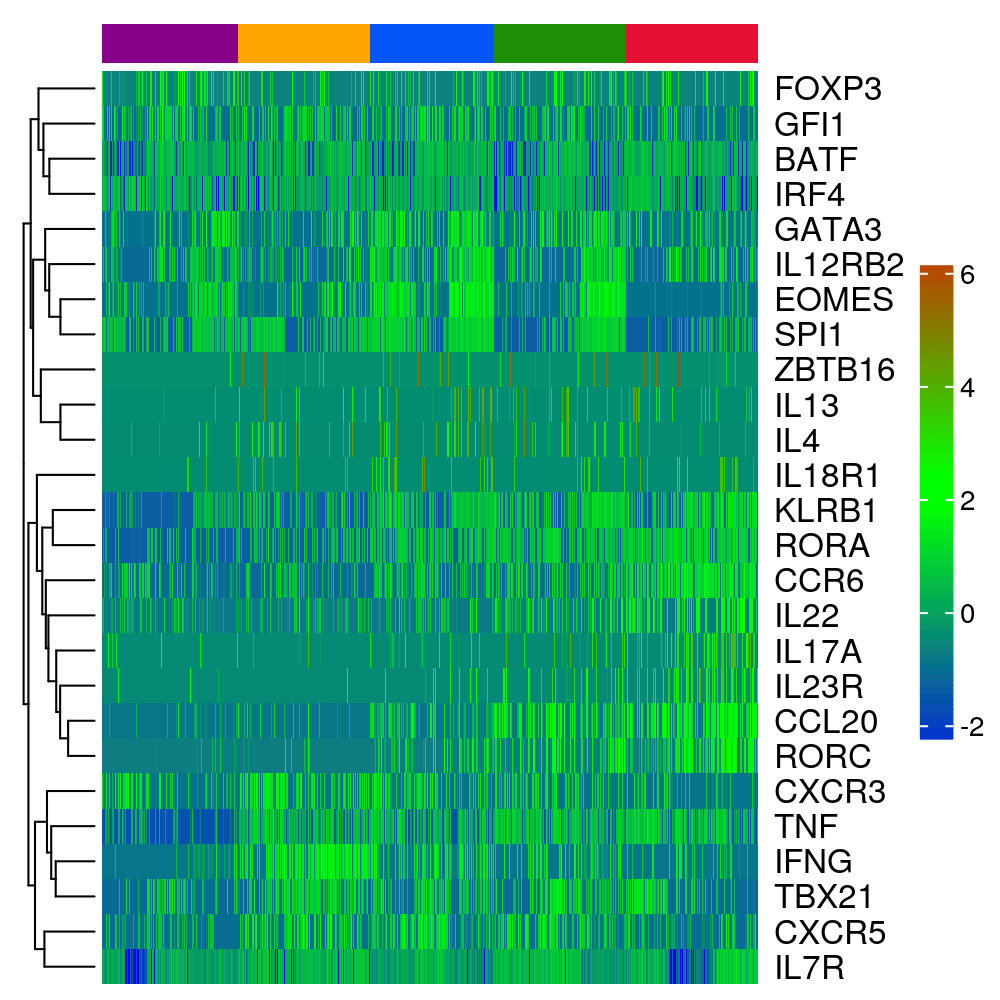

In [38]:
###############
#THE VIEW
###############
options(repr.plot.width=5, repr.plot.height=5, repr.plot.res=200)
expression_heatmap_Object

In [43]:
##################
# SAVE PDF
##################
ggsave(file="../Result/Fluidigm_scRNA_Expression_Heatmap.png", device="png", plot=expression_heatmap_Object, width = 5, height = 5, units = "in", dpi=600)

In [40]:
##################
# SAVE OBJECT
##################
expression_heatmap_Object = plot_grid(expression_heatmap_Object, nrow=1)
saveRDS(expression_heatmap_Object, "../Object/Fluidigm_scRNA_Expression_Heatmap.rds")